# Make Sure the ML Model Fitted Correctly

In [1]:
%load_ext autoreload
%autoreload 2
%env WANDB_SILENT=true

from pathlib import Path
from copy import deepcopy
import matplotlib.pyplot as plt
import pandas as pd
import quantstats as qs
import os
import logging
import sys
import nest_asyncio

nest_asyncio.apply()

while "freqtrade" not in os.listdir():
    os.chdir("..")
    if "freqtrade" in os.listdir():
        nest_asyncio.apply()
        logger = logging.getLogger("freqtrade.ml")
        handler = logging.StreamHandler(stream=sys.stdout)
        handler.setFormatter(logging.Formatter("%(name)s - %(message)s"))
        logger.addHandler(handler)
        logger.setLevel(logging.INFO)

# Freqtrade Imports
from freqtrade.optimize.optimize_reports import text_table_add_metrics
from freqtrade.nbtools.preset import ConfigPreset
from freqtrade.nbtools.backtest import backtest, DataLoader
from freqtrade.nbtools.remote_utils import load_lightning_container, get_lightning_artifact_ver
from freqtrade.nbtools.helper import parse_function_body
from freqtrade.nbtools import plotting, configs
from freqtrade.ml import lightning_utils

# Constants
PATH_MOUNT = Path.cwd().parent / "mount"
DATALOADER = DataLoader(max_n_datasets=5)

# Custom function
def string_templating(string: str, data: dict, strip_doublequotes=False):
    _string = deepcopy(string)
    """Replace [|key|] in string with data["key"] """
    for key, value in data.items():
        to_replace = "[|{}|]".format(key)
        if strip_doublequotes:
            to_replace = "\"[|{}|]\"".format(key)
        if to_replace not in string:
            raise Exception(f"Not found formatting with key '{key}'")
        _string = _string.replace(to_replace, str(value))
    return _string


def start_backtesting(strat_func, lightning_name: str, bt_type: str, version):
    PATH_LOCAL_DATADIR = PATH_MOUNT / "data"
    LIGHTNING_CONTAINER_NAME = lightning_name

    # TODO: Resolve "latest" to number version
    if version == "latest":
        version = get_lightning_artifact_ver(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME)
        print(f"You are using LATEST ({version}) of '{LIGHTNING_CONTAINER_NAME}'")

    lightning_container = load_lightning_container(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME, version=version)
    
    if bt_type == "val":
        timerange = lightning_utils.get_timerange_trainval(lightning_container)
    elif bt_type == "opt":
        timerange = lightning_utils.get_timerange_opt(lightning_container)
    elif bt_type == "test":
        timerange = lightning_utils.get_timerange_test(lightning_container)
    else:
        raise Exception(f"Unknown BT type: {bt_type}")
    
    preset = ConfigPreset(
        name=f"ml_{bt_type}_{LIGHTNING_CONTAINER_NAME}",
        config_dict = configs.DEFAULT,
        path_data=PATH_LOCAL_DATADIR,
        timerange=timerange
    )
    preset.overwrite_config(pairs=lightning_container.config.pairs)

    strategy_code = string_templating(
        parse_function_body(strat_func),
        data={
            "LIGHTNING_CONTAINER_NAME": LIGHTNING_CONTAINER_NAME,
            "VERSION": version
        }
    )
    stats, summary = backtest(preset, strategy_code, dataloader=DATALOADER)
    return stats, summary, preset

env: WANDB_SILENT=true


In [2]:
MODEL_NAME = "15n30-catboost_l3"
MODEL_VER = "v2"
fullname = MODEL_NAME + ":" + MODEL_VER

# Model Validation

freqtrade.nbtools.remote_utils - Load LightningContainer version 'v2' of project: '15n30-catboost_l3' - asset_name: '15n30-catboost_l3'.
freqtrade.nbtools.preset.base_preset - Overwriting pairs (from 0 to 61 pairs)
freqtrade.nbtools.preset.base_preset - Overwriting pairs (from 0 to 61 pairs)
freqtrade.nbtools.preset.base_preset - Setting config for ml_val_15n30-catboost_l3 ...
freqtrade.nbtools.preset.base_preset - Setting arg `datadir` to c:\CS\Python\crypto-collection\freqtrade\mount\data\binance
freqtrade.nbtools.preset.base_preset - Setting arg `timerange` to 20160101-20210501
freqtrade.nbtools.helper - Strategy using minimal_roi: {'30': -1}
freqtrade.nbtools.helper - Strategy using timeframe: 15m
freqtrade.nbtools.helper - Strategy using stoploss: -999
freqtrade.nbtools.helper - Strategy using trailing_stop: False
freqtrade.nbtools.helper - Strategy using trailing_stop_positive_offset: 0.0
freqtrade.nbtools.helper - Strategy using trailing_only_offset_is_reached: False
freqtrade.n

Populating Indicators:   0%|          | 0/60 [00:00<?, ?it/s]

C:\Users\User\AppData\Local\Temp/ipykernel_19748/183904690.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\User\AppData\Local\Temp/ipykernel_19748/183904690.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\User\AppData\Local\Temp/ipykernel_19748/183904690.py:80: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


freqtrade.nbtools.helper - "Backtest" executed in 111.31s
freqtrade.nbtools.backtest - Logging preset...
freqtrade.nbtools.backtest - [LOG PRESET OFFLINE SUCCESS]
freqtrade.nbtools.backtest - Sync preset with name: ml_val_15n30-catboost_l3__backtest-2021-09-03_19-13-48
freqtrade.nbtools.backtest - with random name: sadistic-shinchan-cable
freqtrade.nbtools.backtest - [WANDB LOG PRESET CONTINUES IN BACKGROUND]
Preset Name: ml_val_15n30-catboost_l3__backtest-2021-09-03_19-13-48
freqtrade.nbtools.helper - "Whole Backtesting Process (Backtest + Log)" executed in 124.99s


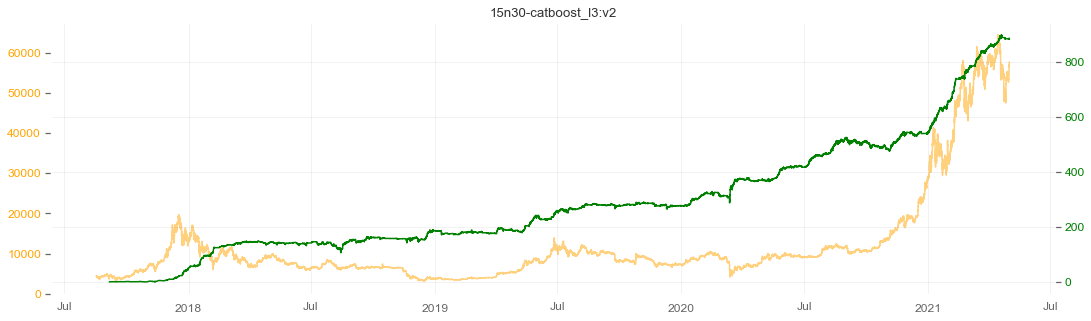

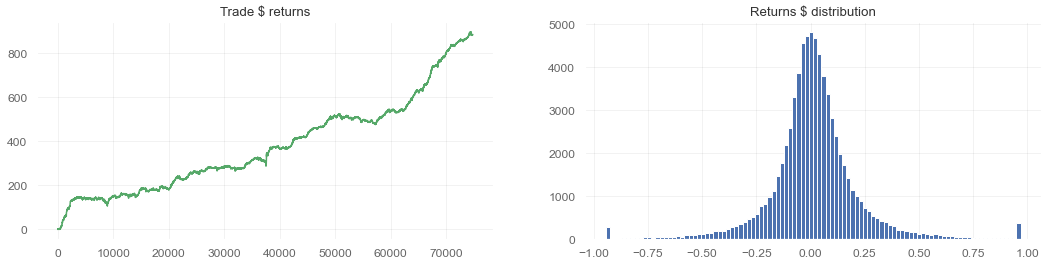

,Portfolio Summary
Trades,74770
Avg. Stake Amount,15.0
Number of Pairs,60
Min Balance,0.15
Max Balance,897.47
Final Balance,884.46
-,-
Wins,39169
Loses,35601
Win Rate,52.39%


freqtrade.nbtools.remote_utils - Adding new row to table...
freqtrade.nbtools.remote_utils - Columns are not identical.
freqtrade.nbtools.remote_utils - New columns    : []
freqtrade.nbtools.remote_utils - Removed columns: ['daily_profit', 'pairlist']
freqtrade.nbtools.remote_utils - Inserting 'None' to removed columns


In [4]:
"""
This strategy will backtested in Train and Validation date.
To make sure the model was fitted correctly, you need to know that you model is predicting accurately in this date.
Create the strategy that BUYS when the ML Model predicts the future is going to UP, and do the same for the sell.
The strategy doesn't need to be trend following, but the final backtest results must profitable steadily.
"""

def val_strategy():
    """ Start Strategy Code """
    from freqtrade.nbtools.strategy import INbStrategy
    from freqtrade.nbtools.remote_utils import load_lightning_container
    from freqtrade.ml.container import LightningContainer
    from pandas import DataFrame
    from functools import reduce
    import numpy as np  # noqa
    import pandas as pd  # noqa
    import talib.abstract as ta
    
    LIGHTNING_CONTAINER_NAME = "[|LIGHTNING_CONTAINER_NAME|]"
    lightning_container = load_lightning_container(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME, version="[|VERSION|]")        
    tp = str(int(lightning_container.config.timeframe.replace("m", "")) * lightning_container.config.num_future_candles)

    class NotebookStrategy(INbStrategy):
        # These attributes are REQUIRED!
        timeframe = lightning_container.config.timeframe
        minimal_roi = {tp: -1}
        stoploss = -999
        startup_candle_count: int = 500
                    
        def populate_indicators(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            dataframe = lightning_container.predict(dataframe)
            num_classes = lightning_container.config.num_classification_classes
            dataframe["argmax_ml"] = dataframe[[f"ml_{x}"for x in range(num_classes)]].idxmax(axis=1)
            return dataframe

        def populate_buy_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            conditions = [
                dataframe["argmax_ml"] == "ml_4",
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'buy'] = 1
                        
            return dataframe

        def populate_sell_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            num_candles_forward = lightning_container.config.num_future_candles
            conditions = [
                dataframe['buy'].shift(num_candles_forward) == 1,
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'sell'] = 1

            return dataframe
    """ End Strategy Code """


stats, summary, preset = start_backtesting(val_strategy, MODEL_NAME, "val", version=MODEL_VER)
trades = pd.DataFrame(stats["strategy"]["NotebookStrategy"]["trades"])
plotting.plot_profits_timerange(trades, timerange=preset.timerange, path_mount=PATH_MOUNT, name=fullname)

# Model x Strategy Optimization

Populating Indicators:   0%|          | 0/60 [00:00<?, ?it/s]

C:\Users\User\AppData\Local\Temp/ipykernel_19748/183904690.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\User\AppData\Local\Temp/ipykernel_19748/183904690.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\User\AppData\Local\Temp/ipykernel_19748/183904690.py:80: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Preset Name: ml_opt_15n30-catboost_l3__backtest-2021-09-03_19-28-58


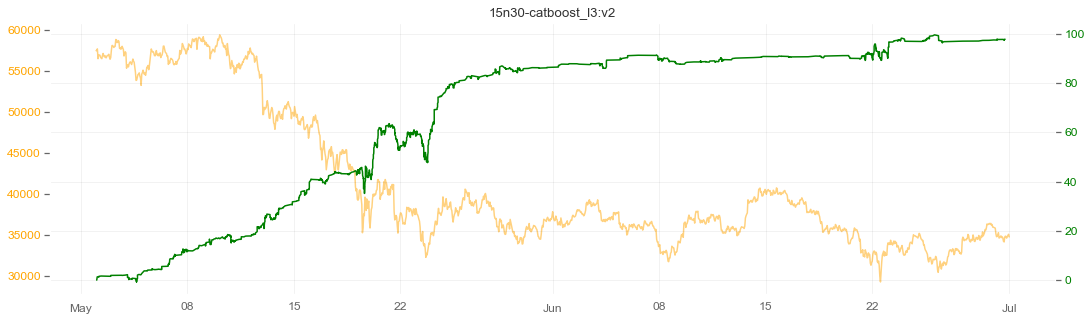

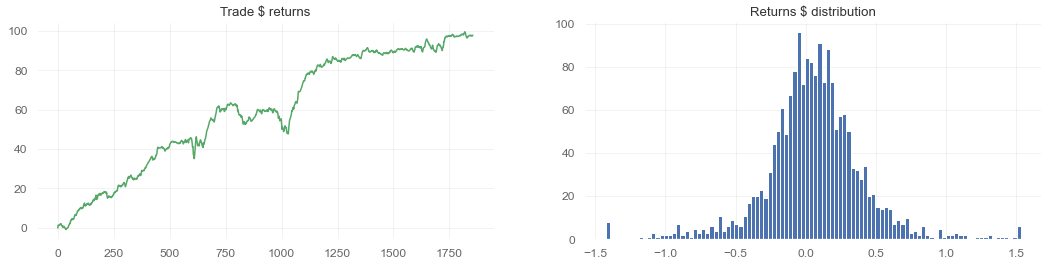

,Portfolio Summary
Trades,1856
Avg. Stake Amount,15.0
Number of Pairs,60
Min Balance,-0.77
Max Balance,99.53
Final Balance,97.75
-,-
Wins,1075
Loses,781
Win Rate,57.92%


In [12]:
"""
Phase where you can trial and error, plug and play model with any strategy, until get the best results.
In this phase, feel free to combine the trained model with a variety of technical indicators or ensemble with another model.

TIP: High threshold no trendline |OR| Low threshold with trendline
"""

def opt_strategy():
    """ Start Strategy Code """
    from freqtrade.nbtools.strategy import INbStrategy
    from freqtrade.nbtools.remote_utils import load_lightning_container
    from freqtrade.ml.container import LightningContainer
    from pandas import DataFrame
    from functools import reduce
    import freqtrade.vendor.qtpylib.indicators as qtpylib
    import numpy as np  # noqa
    import pandas as pd  # noqa
    import talib.abstract as ta
    import pandas_ta as pta
    
    LIGHTNING_CONTAINER_NAME = "[|LIGHTNING_CONTAINER_NAME|]"
    lightning_container = load_lightning_container(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME, version="[|VERSION|]")        
    tp = str(int(lightning_container.config.timeframe.replace("m", "")) * lightning_container.config.num_future_candles)
    
    class NotebookStrategy(INbStrategy):
        # These attributes are REQUIRED!
        timeframe = lightning_container.config.timeframe
        minimal_roi = {tp: -1}
        stoploss = -0.99
        startup_candle_count: int = 500
        
        def populate_indicators(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            dataframe = lightning_container.predict(dataframe)
            num_classes = lightning_container.config.num_classification_classes
            dataframe["argmax_ml"] = dataframe[[f"ml_{x}"for x in range(num_classes)]].idxmax(axis=1)

            # Start adding TA
            dataframe["ema"] = pta.ema(dataframe["close"], length=25)
            dataframe["ema_volume"] = pta.ema(dataframe["volume"], length=100)
            macd = pta.macd(dataframe["close"], fast=4, slow=8, signal=9)
            dataframe = pd.concat([dataframe, macd], axis=1)
            
            return dataframe

        def populate_buy_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            conditions = [
                # Main entry point
                dataframe['argmax_ml'] == "ml_4",
                dataframe['ml_4'] > 0.5,
                # Extra TA filters
                # dataframe['close'] > dataframe['ema'],
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'buy'] = 1
            return dataframe

        def populate_sell_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            num_candles_forward = lightning_container.config.num_future_candles
            conditions = [
                dataframe['buy'].shift(num_candles_forward) == 1,
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'sell'] = 1
            return dataframe
    """ End Strategy Code """


stats, summary, preset = start_backtesting(opt_strategy, MODEL_NAME, "opt", version=MODEL_VER)
trades = pd.DataFrame(stats["strategy"]["NotebookStrategy"]["trades"])
plotting.plot_profits_timerange(trades, timerange=preset.timerange, path_mount=PATH_MOUNT, name=fullname)

# Unbiased Backtesting

Populating Indicators:   0%|          | 0/60 [00:00<?, ?it/s]

C:\Users\User\AppData\Local\Temp/ipykernel_19748/183904690.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\User\AppData\Local\Temp/ipykernel_19748/183904690.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\User\AppData\Local\Temp/ipykernel_19748/183904690.py:80: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Preset Name: ml_test_15n30-catboost_l3__backtest-2021-09-03_19-20-19


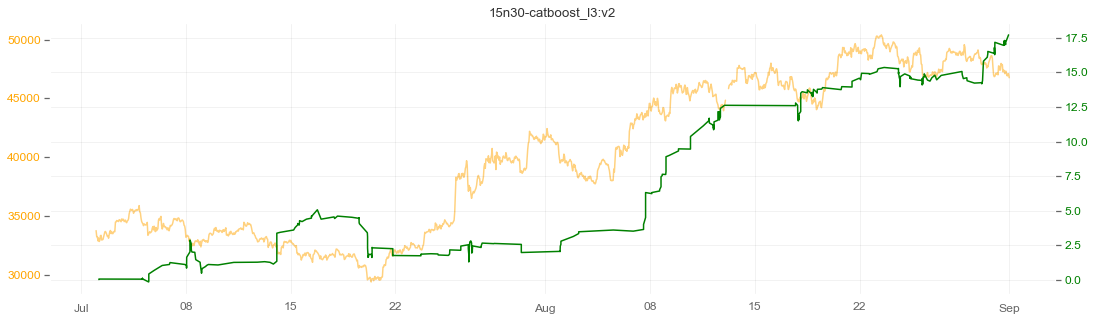

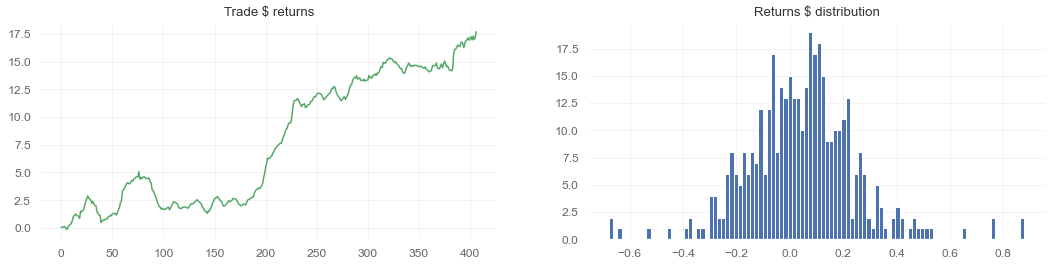

,Portfolio Summary
Trades,407
Avg. Stake Amount,15.0
Number of Pairs,52
Min Balance,-0.14
Max Balance,17.7
Final Balance,17.7
-,-
Wins,240
Loses,167
Win Rate,58.97%


In [8]:
"""
This is a phase where you believe your strategy is now optimized along with your model.
This is not trial and error phase, and you can only run this phase ONCE every "good" optimized strategy to avoid biased results.
"""
stats, summary, preset = start_backtesting(opt_strategy, MODEL_NAME, "test", version=MODEL_VER)
trades = pd.DataFrame(stats["strategy"]["NotebookStrategy"]["trades"])
plotting.plot_profits_timerange(trades, timerange=preset.timerange, path_mount=PATH_MOUNT, name=fullname)